In [1]:
"""
-> Load preprocessed data OK
-> Write a function that takes as input selected chunk id for each questions and ground truth OK
-> Write the different evaluation metrics (accuracy, precision, recall, f1, ?mrr?, map) OK
"""
from utils.evaluation import evaluate_retrieval
from retrieval_judge import RetrievalJudge

/Users/chloed./Library/Caches/pypoetry/virtualenvs/judge-SByZTvc6-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## read jsonl file
judge = RetrievalJudge()
    

No source provided. Loading data from Hugging Face...
Number of processed question loaded: 200
Number of chunks loaded: 28880


In [3]:
ground_truth = judge.data.questions

In [4]:
page_list = judge.get_NQ_dataset_pages()

Dataset downloaded successfully.
Unzipping NQ dataset, this can take a few seconds ...
Processed 200 JSON lines.


In [8]:
judge.get_chunks()

{'0.0': 'Trade winds - wikipedia Trade winds Jump to : navigation , search This article is about the weather phenomenon . For other uses , see Tradewind . The westerlies ( blue arrows ) and trade winds ( yellow and brown arrows )',
 '0.1': "The trade winds are the prevailing pattern of easterly surface winds found in the tropics , within the lower portion of the Earth 's atmosphere , in the lower section of the troposphere near the Earth 's equator . The trade winds blow predominantly from the northeast in the Northern Hemisphere and from the southeast in the Southern Hemisphere , strengthening during the winter and when the Arctic oscillation is in its warm phase . Trade winds have been used by captains of sailing ships to cross",
 '0.2': "the world 's oceans for centuries , and enabled European empire expansion into the Americas and trade routes to become established across the Atlantic and Pacific oceans .",
 '0.3': 'In meteorology , the trade winds act as the steering flow for trop

#### Let's try with a simple example on the dataset using llama index with and without cohere rerank

In [6]:
from llama_index.core.schema import TextNode
chunks = judge.get_chunks() #type: ignore
nodes = []
for key, value in chunks.items():
    node = TextNode(
        text=value,
    )
    src_doc_idx = key
    node.metadata['src_doc_idx'] = src_doc_idx
    nodes.append(node)

In [7]:
from llama_index.core import VectorStoreIndex
index = VectorStoreIndex(nodes)

In [17]:
from llama_index.postprocessor.cohere_rerank import CohereRerank
import os

api_key = os.environ["COHERE_API_KEY"]
cohere_rerank = CohereRerank(api_key=api_key, top_n=10)

In [18]:
retriever = index.as_retriever(similarity_top_k=10)
retriever_w_reranker = index.as_query_engine(
    similarity_top_k=20,
    node_postprocessors=[cohere_rerank],
)

In [19]:
import tqdm
from llama_index.core.schema import QueryBundle
selected_chunk_ids = []
selected_chunk_ids_w_reranker = []
for question in tqdm.tqdm(judge.data.questions):
    if len(question["chunk_ids"]) == 0 or len(question["chunk_ids"]) > 5:
        continue
    query_bundle = QueryBundle(query_str=question["question"] + "?")
    chunks = retriever.retrieve(query_bundle)
    chunks_w_reranker = retriever_w_reranker.retrieve(query_bundle)
    selected_chunk_ids.append({
        "question": question["question"], 
        "chunk_ids": [chunk.metadata["src_doc_idx"]
                    for chunk in chunks]})
    selected_chunk_ids_w_reranker.append({
        "question": question["question"], 
        "chunk_ids": [chunk.metadata["src_doc_idx"]
                    for chunk in chunks_w_reranker]})

100%|██████████| 200/200 [05:12<00:00,  1.56s/it]


In [20]:
results = evaluate_retrieval(ground_truth, selected_chunk_ids) #type: ignore FIXME
results_w_reranker = evaluate_retrieval(ground_truth, selected_chunk_ids_w_reranker) #type: ignore FIXME

Plot saved to retrieval_comparison_with_custom_chunking_10.png


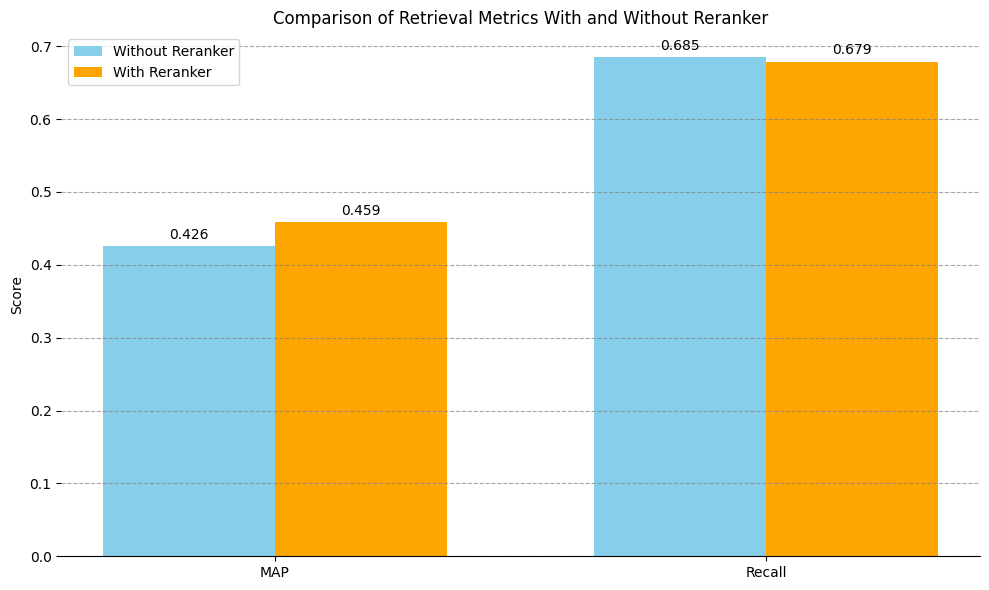

In [21]:
from utils.plotting import plot_retrieval_comparison
plot_retrieval_comparison(results, results_w_reranker, "retrieval_comparison_with_custom_chunking_10.png")